In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
#xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

We're ready to build our first neural network. We will have multiple features we feed into our model, each of which will go through a set of perceptron models to arrive at a response which will be trained to our output.

Like many models we've covered, this can be used as both a regression or classification model.

First, we need to load our dataset. For this example we'll use The Museum of Modern Art in New York's [public dataset](https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv) on their collection.

In [2]:
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [3]:
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

We'll also do a bit of data processing and cleaning, selecting columns of interest and converting URL's to booleans indicating whether they are present.

In [4]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

In [5]:
artworks.head()

,Artist,Nationality,Gender,Date,Department,DateAcquired,URL,ThumbnailURL,Height (cm),Width (cm)
0,Otto Wagner,(Austrian),(Male),1896,Architecture & Design,1996-04-09,True,True,48.6000,168.9000
1,Christian de Portzamparc,(French),(Male),1987,Architecture & Design,1995-01-17,True,True,40.6401,29.8451
2,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,34.3000,31.8000
3,Bernard Tschumi,(),(Male),1980,Architecture & Design,1995-01-17,True,True,50.8000,50.8000
4,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,38.4000,19.1000


## Building a Model

Now, let's see if we can use multi-layer perceptron modeling (or "MLP") to see if we can classify the department a piece should go into using everything but the department name.

Before we import MLP from SKLearn and establish the model we first have to ensure correct typing for our data and do some other cleaning.

In [6]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

The `DateAcquired` column is an object. Let's transform that to a datetime object and add a feature for just the year the artwork was acquired.

In [7]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

Great. Let's do some more miscellaneous cleaning.

In [8]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date', 'URL', 'ThumbnailURL'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)
Y = artworks.Department

In [9]:
X.head(10)

,Height (cm),Width (cm),YearAcquired,Gender_(),Gender_(Female),Gender_(Male),Gender_(male),Gender_\(multiple_persons\),(),(Albanian),...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,48.6000,168.9000,1996,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.6401,29.8451,1995,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34.3000,31.8000,1997,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50.8000,50.8000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38.4000,19.1000,1997,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[1.72852506e-01 1.60669781e-01 2.11145784e-01 1.03168587e-02
 3.61427653e-03 6.71947375e-03 4.82098647e-05 5.08471429e-03
 1.05396234e-02 2.58380269e-05 6.59185778e-07 2.06423146e-02
 1.33061391e-03 5.27590386e-04 1.34488589e-03 2.30110076e-06
 1.74085161e-05 2.04054915e-03 1.16714825e-05 1.01315766e-04
 1.97189156e-03 3.98327801e-03 3.75537694e-05 9.32573365e-05
 4.28947720e-05 1.37097702e-05 1.25322465e-03 8.79594474e-04
 5.18357251e-04 1.98331541e-03 3.21060993e-05 8.62970291e-06
 5.61081017e-05 8.68925218e-04 9.41177406e-04 1.61882486e-03
 1.55004980e-05 7.86761590e-04 5.14081189e-03 1.22896339e-05
 2.23215262e-04 4.16832175e-06 2.68262538e-05 8.79722035e-04
 1.67097485e-02 1.35472245e-05 3.48184815e-03 1.29016170e-05
 1.87209662e-04 1.33253863e-04 9.22900058e-06 8.72575036e-05
 5.23129533e-04 9.54644918e-05 9.09727333e-04 4.67050117e-05
 1.95280655e-04 8.43386058e-04 3.26179149e-03 9.16148330e-07
 2.78956089e-03 1.66506723e-05 3.72064411e-04 6.26817432e-06
 3.27832862e-04 2.266115

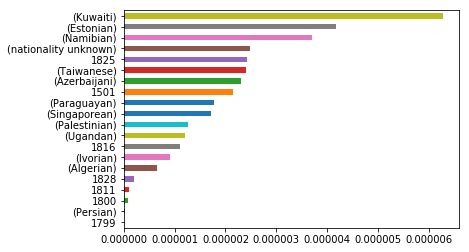

In [10]:
# plot feature importance
#feat_importance = plot_importance(model)
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nsmallest(20).plot(kind='barh')
plt.show()

In [11]:
X.drop(['1799', '1501', '1800', '1828', '1816', '(Palestinian)', 
        '(Ugandan)', '(Paraguayan)', '(Algerian)', '1811', '(Persian)', '(Azerbaijani)', '1825', '(Singaporean)', '(Coptic)', '(Ivorian)', 
        '(Estonian)', '(Ghanaian)', '(Guyanese)', '1832'], 
        axis=1, inplace=True)

In [18]:
X.head(10)

,Height (cm),Width (cm),YearAcquired,Gender_(),Gender_(Female),Gender_(Male),Gender_(male),Gender_\(multiple_persons\),(),(Albanian),...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,48.6000,168.9000,1996,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.6401,29.8451,1995,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34.3000,31.8000,1997,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50.8000,50.8000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38.4000,19.1000,1997,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,35.6000,45.7000,1995,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Alright! We've done our prep, let's build the model.
# Neural networks are hugely computationally intensive.
# This may take several minutes to run.

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,2))
mlp.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [14]:
mlp.score(X, Y)

0.520762795786138

In [15]:
Y.value_counts()/len(Y)

Prints & Illustrated Books    0.520763
Photography                   0.227735
Architecture & Design         0.114202
Drawings                      0.103592
Painting & Sculpture          0.033707
Name: Department, dtype: float64

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

array([0.52074689, 0.52074689, 0.52074884, 0.52074884, 0.52082253])

Now we got a lot of information from all of this. Firstly we can see that the model seems to overfit, though there is still so remaining performance when validated with cross validation. This is a feature of neural networks that aren't given enough data for the number of features present. _Neural networks, in general, like_ a lot _of data_. You may also have noticed something also about neural networks: _they can take a_ long _time to run_. Try increasing the layer size by adding a zero. Feel free to interrupt the kernel if you don't have time...

Also note that we created bools for artist's name but left them out. Both of the above points are the reason for that. It would take much longer to run and it would be much more prone to overfitting.

## Model parameters

Now, before we move on and let you loose with some tasks to work on the model, let's go over the parameters.

We included one parameter: hidden layer size. Remember in the previous lesson, when we talked about layers in a neural network. This tells us how many and how big to make our layers. Pass in a tuple that specifies each layer's size. Our network is 1000 neurons wide and one layer. (100, 4, ) would create a network with two layers, one 100 wide and the other 4.

How many layers to include is determined by two things: computational resources and cross validation searching for convergence. It's generally less than the number of input variables you have.

You can also set an alpha. Neural networks like this use a regularization parameter that penalizes large coefficients just like we discussed in the advanced regression section. Alpha scales that penalty.

Lastly, we'll discuss the activation function. The activation function determines whether the output from an individual perceptron is binary or continuous. By default this is a 'relu', or 'rectified linear unit function' function. In the exercise we went through earlier we used this binary function, but we discussed the _sigmoid_ as a reasonable alternative. The _sigmoid_ (called 'logistic' by SKLearn because it's a 'logistic sigmoid function') allows for continuous variables between 0 and 1, which allows for a more nuanced model. It does come at the cost of increased computational complexity.

If you want to learn more about these, study [activation functions](https://en.wikipedia.org/wiki/Activation_function) and [multilayer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron). The [Deep Learning](http://www.deeplearningbook.org/) book referenced earlier goes into great detail on the linear algebra involved.

You could also just test the models with cross validation. Unless neural networks are your specialty cross validation should be sufficient.

For the other parameters and their defaults, check out the [MLPClassifier documentaiton](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

## Drill: Playing with layers

Now it's your turn. Using the space below, experiment with different hidden layer structures. You can try this on a subset of the data to improve runtime. See how things vary. See what seems to matter the most. Feel free to manipulate other parameters as well. It may also be beneficial to do some real feature selection work...

In [17]:
# Your code here. Experiment with hidden layers to build your own model.

